# Overfitting in the centralized model?
---


:::: {style="display: flex; "}

:::

### 99a_insurance_centralized_wrapup.ipynb

**No Overfitting**

![](../output/experiments/00_central/results/training_performance.png)

:::

:::

### 99b_insurance_federated_wrapup.ipynb

**Overfitting**


![](../output/experiments/02_central_new/results/training_performance_rsq.png)


:::

::::

## Setup
---

### Imports
---

In [32]:
# imports

# suppress tf debug logging
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

#0 = all messages are logged (default behavior)
#1 = INFO messages are not printed
#2 = INFO and WARNING messages are not printed
#3 = INFO, WARNING, and ERROR messages are not printed
# S. https://stackoverflow.com/questions/35911252/disable-tensorflow-debugging-information

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tqdm
import tensorflow_federated as tff
import tensorflow as tf
from sklearn.model_selection import RepeatedKFold, train_test_split, RepeatedStratifiedKFold

from keras.callbacks import CSVLogger

from FLutils import load_df, create_keras_model, model_fn, prep_fed_train, prep_fed_test, train_model, train_fed, plot_hist
#train_model,
#import FLutils

# logging path
log_path = '../output/experiments/04_debug/' 

### Data
---

In [2]:
# ingest data

df_locs = [
    '../output/data/insurance-clean.csv',
    "https://raw.githubusercontent.com/Olhaau/fl-official-statistics-addon/main/output/data/insurance-clean.csv"
]

df = load_df(df_locs)
df.head(3)

loaded data from ../output/data/insurance-clean.csv


,age,sex,bmi,children,smoker,region,charges,region0,region1,region2,region3
0,0.021739,0.0,0.321227,0.0,1.0,southwest,16884.9240,0.0,0.0,0.0,1.0
1,0.000000,1.0,0.479150,0.2,0.0,southeast,1725.5523,0.0,0.0,1.0,0.0
2,0.217391,1.0,0.458434,0.6,0.0,southeast,4449.4620,0.0,0.0,1.0,0.0


In [3]:
# select features and target (first column)
# =========================================
features = ['age', 'sex', 'bmi', 'children', 'smoker'
            , 'region0', 'region1', 'region2', 'region3']#[:5]
target = 'charges'

df.loc[:, [target] + features].head(3)

,charges,age,sex,bmi,children,smoker,region0,region1,region2,region3
0,16884.9240,0.021739,0.0,0.321227,0.0,1.0,0.0,0.0,0.0,1.0
1,1725.5523,0.000000,1.0,0.479150,0.2,0.0,0.0,0.0,1.0,0.0
2,4449.4620,0.217391,1.0,0.458434,0.6,0.0,0.0,0.0,1.0,0.0


### Model specifics
---

In [4]:
# model
model = create_keras_model(compile = True)
model.summary()
model.get_compile_config()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                400       
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dense_2 (Dense)             (None, 20)                820       
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,881
Trainable params: 2,881
Non-trainable params: 0
_________________________________________________________________


{'optimizer': {'module': 'keras.optimizers.legacy',
  'class_name': 'Adam',
  'config': {'name': 'Adam',
   'learning_rate': 0.05,
   'decay': 0.0,
   'beta_1': 0.9,
   'beta_2': 0.999,
   'epsilon': 1e-07,
   'amsgrad': False},
  'registered_name': None},
 'loss': 'mean_squared_error',
 'metrics': ['mae',
  'mean_squared_error',
  {'module': 'sklearn.metrics._regression',
   'class_name': 'function',
   'config': 'r2_score',
   'registered_name': 'r2_score'}],
 'loss_weights': None,
 'weighted_metrics': None,
 'run_eagerly': True,
 'steps_per_execution': None,
 'jit_compile': None}

In [5]:
print('Defaults of FLutils.train_model')

dict(zip(
    train_model.__code__.co_varnames[3:-3],
    train_model.__defaults__
))

# S. help(train_model)

Defaults of FLutils.train_model


{'epochs': 100,
 'batch_size': 128,
 'shuffle': True,
 'validation_split': 0.2,
 'verbose': 0,
 'output_msr': 'loss',
 'seed': 42}

## Experiments
---

In [6]:
n_epochs = 100
n_folds = 5
n_reps = 1

### 1 Complete data for training
---

r2_score  = 0.8352, time = 52.1 sec


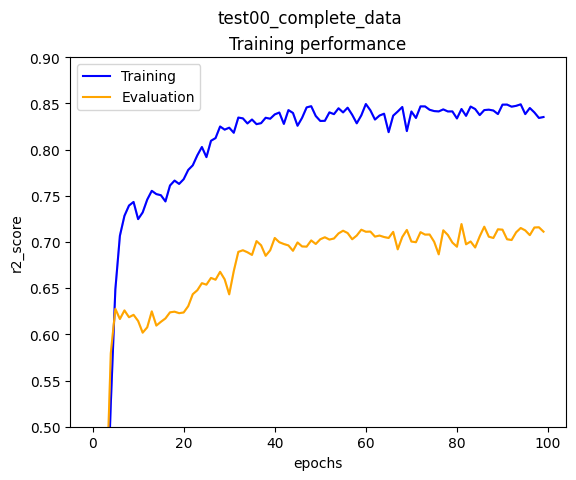

In [7]:
experiment_name = "test00_complete_data"    # train + eval    

# logger setup
experiment_path = log_path + experiment_name
if not os.path.exists(experiment_path+ '/logs'): os.makedirs(experiment_path + '/logs')
if not os.path.exists(experiment_path + '/out'): os.makedirs(experiment_path + '/out')

eval_name = ""      

X_train, y_train = df[features], df[target]

model = create_keras_model(compile = True)

hist = train_model(
    model, X_train, y_train, 
    epochs = n_epochs, 
    output_msr = "r2_score",
    callbacks = [CSVLogger(
        "%s/logs/log_%s_%s.csv" % 
        (experiment_path, eval_name, experiment_name)
        
        #experiment_path + "/logs/" + eval_name + '_log.csv'  , separator =";"
        )]
    )

plot_hist(
    hist.history, title = experiment_name,
    savepath = "%s/out/perf_train_%s_%s.png" % 
    (experiment_path, eval_name, experiment_name)
)


### 2 Stratified K fold (sklearn - considering regions)
---

r2_score  = 0.8578, time = 38.1 sec
r2_score  = 0.8538, time = 38.0 sec
r2_score  = 0.8669, time = 36.9 sec
r2_score  = 0.8361, time = 38.2 sec
r2_score  = 0.8437, time = 36.6 sec


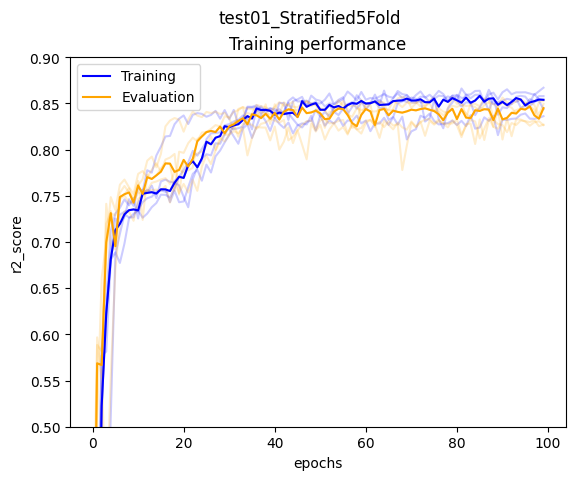

In [8]:
experiment_name = "test01_Stratified5Fold"   # train + eval     

# logger setup
experiment_path = log_path + experiment_name
if not os.path.exists(experiment_path+ '/logs'): os.makedirs(experiment_path + '/logs')
if not os.path.exists(experiment_path + '/out'): os.makedirs(experiment_path + '/out')

cv = RepeatedStratifiedKFold(n_splits = n_folds, n_repeats = n_reps, random_state = 42)
hists = []

i = 0
for train, _ in cv.split(df, df.region): 
    
    eval_name = "eval" + str(i)
    i += 1
    
    X_train = df.loc[train, features]
    y_train = df.loc[train, target]
    
    model = create_keras_model(compile = True)
    
    hist = train_model(
        model, X_train, y_train, 
        epochs = n_epochs, 
        output_msr = "r2_score",
        callbacks = [CSVLogger(
            "%s/logs/log_%s_%s.csv" % 
            (experiment_path, eval_name, experiment_name)
            )]
    )
    hists.append(hist)
    

plot_hist(
    [h.history for h in hists], title = experiment_name,
    savepath = "%s/out/perf_train_%s_%s.png" % 
    (experiment_path, eval_name, experiment_name)
)


### 3 K fold (sklearn)
---

r2_score  = 0.8426, time = 37.0 sec
r2_score  = 0.8438, time = 37.3 sec
r2_score  = 0.8527, time = 39.7 sec
r2_score  = 0.8518, time = 41.6 sec
r2_score  = 0.8543, time = 40.2 sec


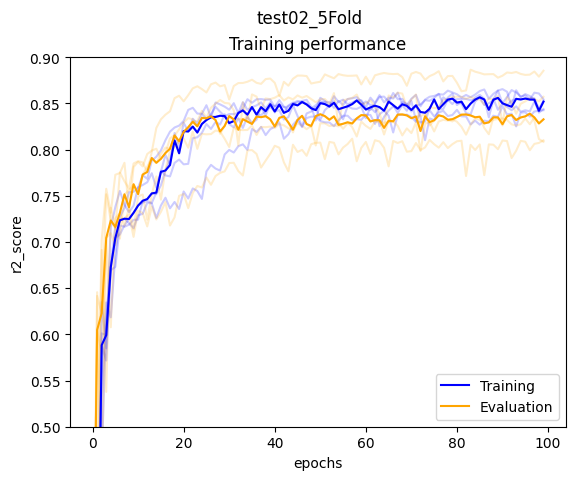

In [9]:
experiment_name = "test02_5Fold"        # train + eval

# logger setup
experiment_path = log_path + experiment_name
if not os.path.exists(experiment_path + '/logs'): os.makedirs(experiment_path + '/logs')
if not os.path.exists(experiment_path + '/out'): os.makedirs(experiment_path + '/out')


cv = RepeatedKFold(n_splits = n_folds, n_repeats = n_reps, random_state = 42)
hists = []

i = 0
for train, _ in cv.split(df, df.region): 
    
    eval_name = "fold" + str(i)
    i += 1
    
    X_train = df.loc[train, features]
    y_train = df.loc[train, target]
    
    model = create_keras_model(compile = True)
    
    hist = train_model(
        model, X_train, y_train, 
        epochs = n_epochs, 
        output_msr = "r2_score",
        callbacks = [CSVLogger(
            "%s/logs/log_%s_%s.csv" % 
            (experiment_path, eval_name, experiment_name)
            )]
    )
    hists.append(hist)
    

plot_hist(
    [h.history for h in hists], title = experiment_name,
    savepath = "%s/out/perf_train_%s.png" % 
    (experiment_path, experiment_name)
)

### 4 80pct sample for training
---

r2_score  = 0.8651, time = 39.4 sec
r2_score  = 0.8460, time = 37.8 sec
r2_score  = 0.8165, time = 36.7 sec
r2_score  = 0.8357, time = 36.8 sec
r2_score  = 0.8442, time = 36.6 sec


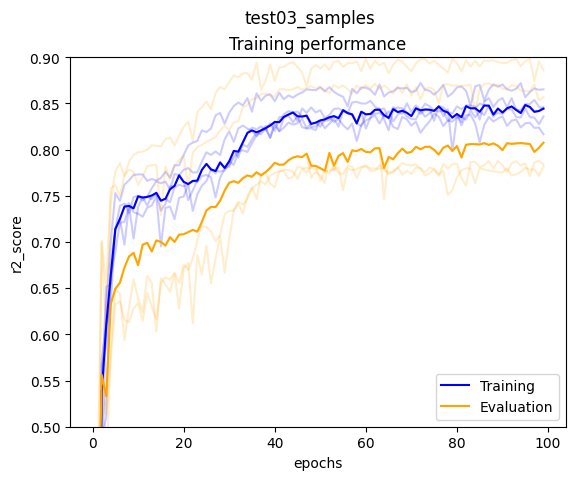

In [10]:
experiment_name = "test03_samples"        # train + eval

# logger setup
experiment_path = log_path + experiment_name
if not os.path.exists(experiment_path + '/logs'): os.makedirs(experiment_path + '/logs')
if not os.path.exists(experiment_path + '/out'): os.makedirs(experiment_path + '/out')

hists = []

for i in range(n_folds): 
    
    eval_name = "fold" + str(i)
    
    df_train = df.sample(frac = .8, random_state = 42 + 11 * i)
    X_train, y_train = df_train[features], df_train[target]

    
    model = create_keras_model(compile = True)
    
    hist = train_model(
        model, X_train, y_train, 
        epochs = n_epochs, 
        output_msr = "r2_score",
        callbacks = [CSVLogger(
            "%s/logs/log_%s_%s.csv" % 
            (experiment_path, eval_name, experiment_name)
            )]
    )
    hists.append(hist)
    

plot_hist(
    [h.history for h in hists], title = experiment_name,
    savepath = "%s/out/perf_train_%s.png" % 
    (experiment_path, experiment_name)
)


r2_score  = 0.8360, time = 40.9 sec
r2_score  = 0.8435, time = 40.2 sec
r2_score  = 0.8398, time = 39.5 sec
r2_score  = 0.8371, time = 39.3 sec
r2_score  = 0.8268, time = 40.0 sec


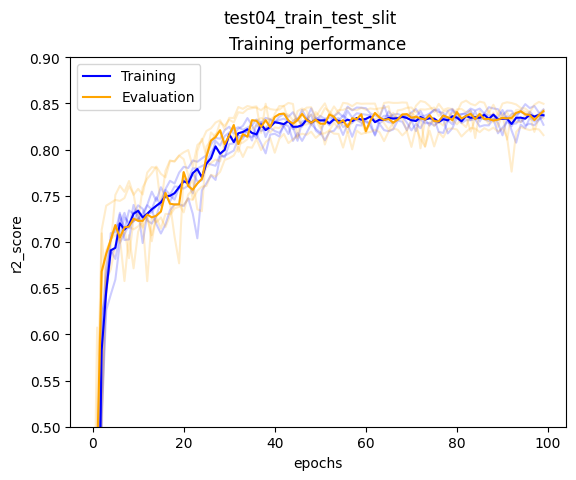

In [34]:
experiment_name = "test04_train_test_slit"        # train + eval

# logger setup
experiment_path = log_path + experiment_name
if not os.path.exists(experiment_path + '/logs'): os.makedirs(experiment_path + '/logs')
if not os.path.exists(experiment_path + '/out'): os.makedirs(experiment_path + '/out')

hists = []

for i in range(n_folds): 
    
    eval_name = "fold" + str(i)
    
    df_train = train_test_split(df, test_size = .2, random_state=42 + 11 * i)[0]
    X_train, y_train = df_train[features], df_train[target]

    
    model = create_keras_model(compile = True)
    
    hist = train_model(
        model, X_train, y_train, 
        epochs = n_epochs, 
        output_msr = "r2_score",
        callbacks = [CSVLogger(
            "%s/logs/log_%s_%s.csv" % 
            (experiment_path, eval_name, experiment_name)
            )]
    )
    hists.append(hist)
    

plot_hist(
    [h.history for h in hists], title = experiment_name,
    savepath = "%s/out/perf_train_%s.png" % 
    (experiment_path, experiment_name)
)


### 5 80ct sample per region combined

r2_score  = 0.8294, time = 43.6 sec
r2_score  = 0.8406, time = 42.8 sec
r2_score  = 0.8569, time = 40.9 sec
r2_score  = 0.8681, time = 40.6 sec
r2_score  = 0.8780, time = 40.4 sec


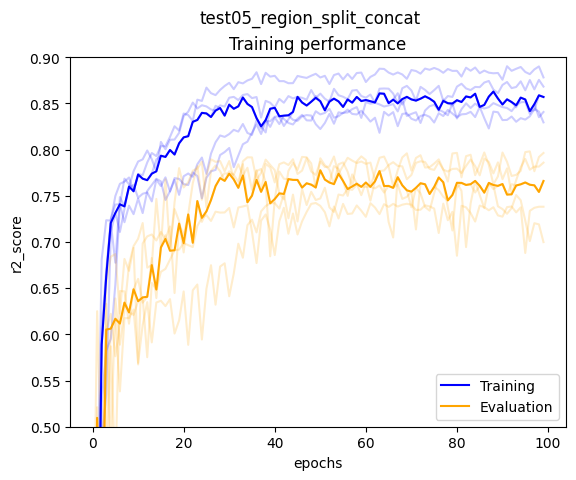

In [33]:
experiment_name = "test05_region_split_concat"        # train + eval

# logger setup
experiment_path = log_path + experiment_name
if not os.path.exists(experiment_path + '/logs'): os.makedirs(experiment_path + '/logs')
if not os.path.exists(experiment_path + '/out'): os.makedirs(experiment_path + '/out')

regions = df.region.unique()


hists = []

for i in range(n_folds): 
    
    eval_name = "fold" + str(i)
    
    df_train = pd.concat(
        [df.loc[df.region == region].sample(frac= 0.8, random_state = 42 + i * 11) 
         for region in regions]
    )
    X_train, y_train = df_train[features], df_train[target]

    
    model = create_keras_model(compile = True)
    
    hist = train_model(
        model, X_train, y_train, 
        epochs = n_epochs, 
        output_msr = "r2_score",
        callbacks = [CSVLogger(
            "%s/logs/log_%s_%s.csv" % 
            (experiment_path, eval_name, experiment_name)
            )]
    )
    hists.append(hist)
    

plot_hist(
    [h.history for h in hists], title = experiment_name,
    savepath = "%s/out/perf_train_%s.png" % 
    (experiment_path, experiment_name)
)


### Experiment Template

In [11]:
# experiment_name = "xxx"        # train + eval

# # logger setup
# experiment_path = log_path + experiment_name
# if not os.path.exists(experiment_path + '/logs'): os.makedirs(experiment_path + '/logs')
# if not os.path.exists(experiment_path + '/out'): os.makedirs(experiment_path + '/out')


# cv = RepeatedKFold(n_splits = n_folds, n_repeats = n_reps, random_state = 42)
# hists = []

# i = 0
# for train, _ in cv.split(df, df.region): 
    
#     eval_name = "fold" + str(i)
#     i += 1
    
#     X_train = df.loc[train, features]
#     y_train = df.loc[train, target]
    
#     model = create_keras_model(compile = True)
    
#     hist = train_model(
#         model, X_train, y_train, 
#         epochs = n_epochs, 
#         output_msr = "r2_score",
#         callbacks = [CSVLogger(
#             "%s/logs/log_%s_%s.csv" % 
#             (experiment_path, eval_name, experiment_name)
#             )]
#     )
#     hists.append(hist)
    

# plot_hist(
#     [h.history for h in hists], title = experiment_name,
#     savepath = "%s/out/perf_train_%s.png" % 
#     (experiment_path, experiment_name)
# )

## Playground
---

r2_score  = 0.8346, time = 48.3 sec


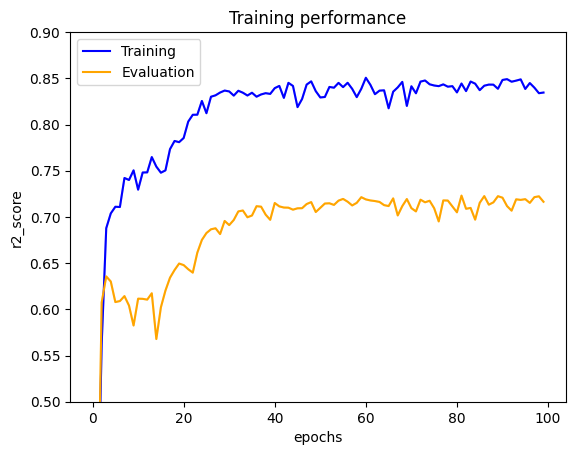

In [12]:
# complete data
X_train, y_train = df[features], df[target]

model = create_keras_model(compile = True)

hist = train_model(
    model, X_train, y_train, 
    epochs = n_epochs, output_msr = "r2_score")

plot_hist(hist.history)

r2_score  = 0.8654, time = 36.8 sec
r2_score  = 0.8654, time = 37.0 sec
r2_score  = 0.8654, time = 36.6 sec


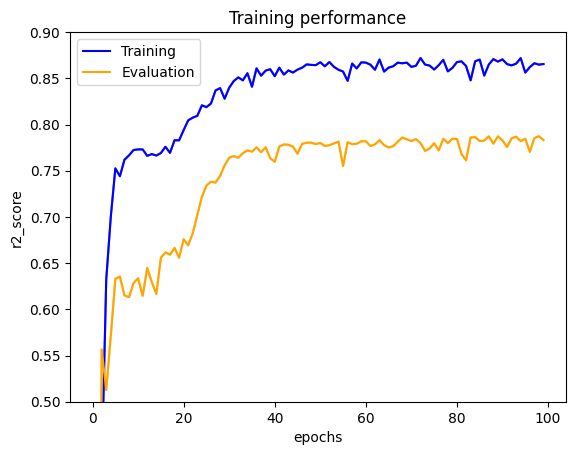

In [13]:
# samples
hists = []

for i in range(3):
    df_train = df.sample(frac = .8, random_state = 42)

    X_train, y_train = df_train[features], df_train[target]

    model = create_keras_model(compile = True)

    hist = train_model(
        model, X_train, y_train, 
        epochs = 100#n_epochs
        , output_msr = "r2_score")
    hists.append(hist)

plot_hist([hist.history for hist in hists])

r2_score  = 0.8360, time = 36.9 sec


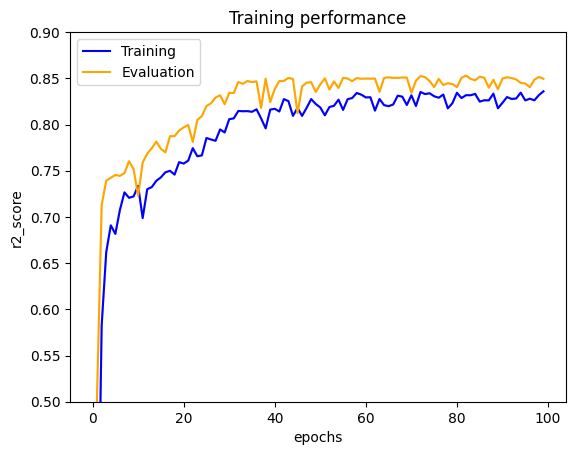

In [14]:
df_train = train_test_split(df, test_size = .2, random_state=42)[0]

X_train, y_train = df_train[features], df_train[target]

model = create_keras_model(compile = True)

hist = train_model(
    model, X_train, y_train, 
    epochs = 100#n_epochs
    , output_msr = "r2_score")

plot_hist(hist.history)

r2_score  = 0.8287, time = 37.2 sec


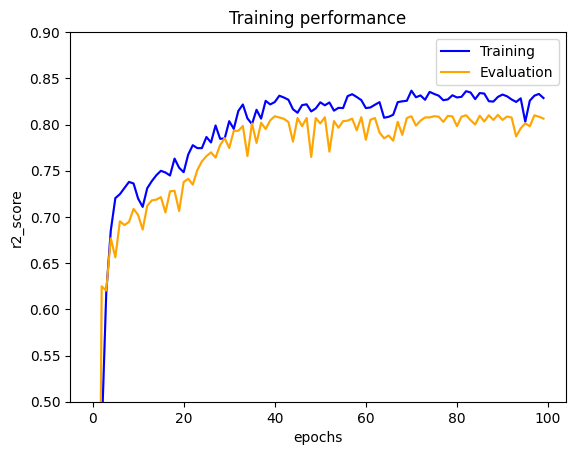

In [15]:
df_train = train_test_split(df, test_size = .2, random_state=20)[0]

X_train, y_train = df_train[features], df_train[target]

model = create_keras_model(compile = True)

hist = train_model(
    model, X_train, y_train, 
    epochs = 100#n_epochs
    , output_msr = "r2_score")

plot_hist(hist.history)

## Analysis
---

In [16]:
experiments = os.listdir("../output/experiments/04_debug")

logs = []
for ex in experiments:
    log_files = os.listdir("../output/experiments/04_debug/%s/logs" % ex)
    for log_file in log_files:
        log_path = "../output/experiments/04_debug/%s/logs/%s" % (ex, log_file)
        logs.append(pd.read_csv(log_path).assign(experiment = ex))
    

In [17]:
#pd.concat(logs).head()

In [18]:
#for log in logs:
#    plot_hist(log)